Epoch [10/100], Train Loss: 0.3044, Val Loss: 0.4341
Epoch [20/100], Train Loss: 0.2778, Val Loss: 0.3968
Epoch [30/100], Train Loss: 0.2641, Val Loss: 0.3360
Epoch [40/100], Train Loss: 0.3566, Val Loss: 0.3115
Epoch [50/100], Train Loss: 0.2645, Val Loss: 0.3311
Epoch [60/100], Train Loss: 0.2655, Val Loss: 0.2925
Epoch [70/100], Train Loss: 0.2489, Val Loss: 0.2892
Epoch [80/100], Train Loss: 0.2462, Val Loss: 0.2819
Epoch [90/100], Train Loss: 0.2372, Val Loss: 0.2985
Epoch [100/100], Train Loss: 0.2420, Val Loss: 0.3035


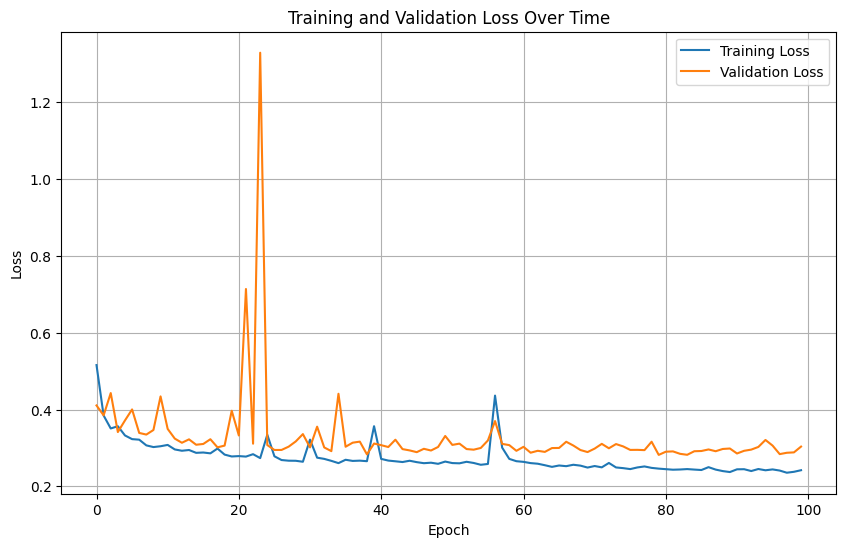


Validation Metrics:
MSE: 0.3034
RMSE: 0.5508
MAE: 0.3735

Test Metrics:
MSE: 0.2983
RMSE: 0.5462
MAE: 0.3744


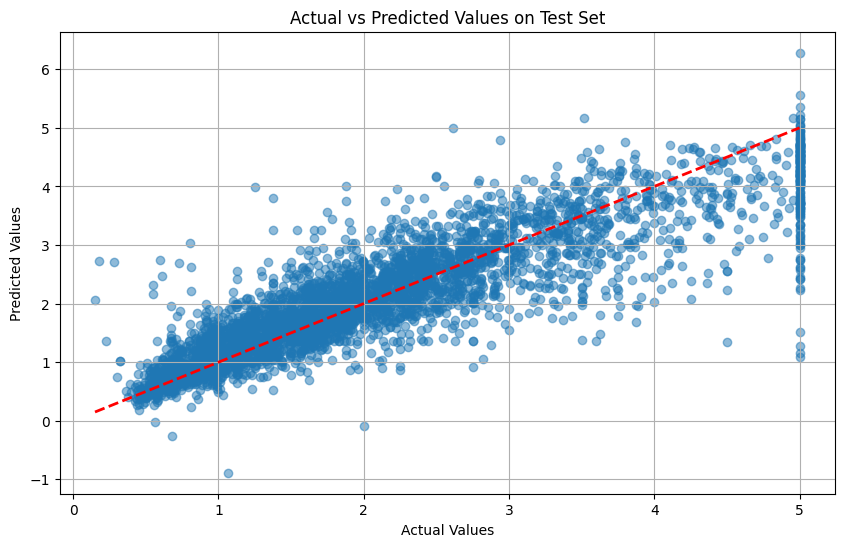

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集、验证集和测试集
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# 将数据转换为PyTorch张量
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val) 
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

# 创建DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# 定义神经网络模型
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(8, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# 初始化模型、损失函数和优化器
model = RegressionModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 训练参数
num_epochs = 100

# 用于记录损失值
train_losses = []
val_losses = []

# 训练模型
for epoch in range(num_epochs):
    # 将模型设置为训练模式
    model.train()
    
    # 训练循环
    train_loss = 0.0
    for inputs, targets in train_loader:
        
        optimizer.zero_grad()
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # 计算平均训练损失
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # 计算验证损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            val_outputs = model(inputs)
            val_batch_loss = criterion(val_outputs, targets)
            val_loss += val_batch_loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
    
    # 每10个epoch打印一次训练损失和验证损失
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# 绘制训练过程中的损失变化
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# 评估模型
model.eval()
with torch.no_grad():
    # 在验证集上评估
    val_mse = 0.0
    val_mae = 0.0
    for inputs, targets in val_loader:
        y_pred = model(inputs)
        val_mse += ((y_pred - targets) ** 2).mean().item() * inputs.size(0)
        val_mae += torch.abs(y_pred - targets).mean().item() * inputs.size(0)
    
    val_mse /= len(val_dataset)
    val_mae /= len(val_dataset)
    val_rmse = np.sqrt(val_mse)
    
    print('\nValidation Metrics:')
    print(f'MSE: {val_mse:.4f}')
    print(f'RMSE: {val_rmse:.4f}')
    print(f'MAE: {val_mae:.4f}')
    
    # 在测试集上评估
    test_mse = 0.0
    test_mae = 0.0
    all_targets = []
    all_predictions = []
    
    for inputs, targets in test_loader:
        y_pred = model(inputs)
        test_mse += ((y_pred - targets) ** 2).mean().item() * inputs.size(0)
        test_mae += torch.abs(y_pred - targets).mean().item() * inputs.size(0)
        
        # 收集所有预测和真实值用于绘图
        all_targets.append(targets)
        all_predictions.append(y_pred)
    
    test_mse /= len(test_dataset)
    test_mae /= len(test_dataset)
    test_rmse = np.sqrt(test_mse)
    
    print('\nTest Metrics:')
    print(f'MSE: {test_mse:.4f}')
    print(f'RMSE: {test_rmse:.4f}')
    print(f'MAE: {test_mae:.4f}')
    
    # 合并所有批次的数据用于绘图
    y_test_plot = torch.cat(all_targets, dim=0)
    y_pred_test_plot = torch.cat(all_predictions, dim=0)

# 绘制预测值与真实值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(y_test_plot.numpy(), y_pred_test_plot.numpy(), alpha=0.5)
plt.plot([y_test_plot.min().item(), y_test_plot.max().item()], 
         [y_test_plot.min().item(), y_test_plot.max().item()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.grid(True)
plt.show()
